In [ ]:

import os, torch, pathlib
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = os.environ.get("BASE_DIR", "/workspace/vspec")
pathlib.Path(BASE_DIR).mkdir(parents=True, exist_ok=True)
for sub in ("data", "ckpt", "hf/hub", "logs", "profiles"):
   pathlib.Path(f"{BASE_DIR}/{sub}").mkdir(parents=True, exist_ok=True)

os.environ["HF_HOME"] = f"{BASE_DIR}/hf"
os.environ["TRANSFORMERS_CACHE"] = f"{BASE_DIR}/hf/hub"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"


os.environ["DATA_PATH"] = f"{BASE_DIR}/data/vspec_train.jsonl"
os.environ["VERIFIER_PATH"] = f"{BASE_DIR}/ckpt/vspec_verifier.pt"
os.environ["ENHANCED_VERIFIER_PATH"] = f"{BASE_DIR}/ckpt/vspec_verifier_enhanced.pt"

os.environ["CUDA_LAUNCH_BLOCKING"] = "0" 
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.set_grad_enabled(False)

if torch.cuda.is_available():
   torch.cuda.empty_cache()
   torch.cuda.set_per_process_memory_fraction(0.95)  

print("BASE_DIR      :", BASE_DIR)
print("DATA_PATH     :", os.environ["DATA_PATH"])
print("VERIFIER_PATH :", os.environ["VERIFIER_PATH"])
print("ENHANCED_PATH :", os.environ["ENHANCED_VERIFIER_PATH"])
print("Visible GPUs  :", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
   print(f"  cuda:{i} -> {torch.cuda.get_device_name(i)}")
   props = torch.cuda.get_device_properties(i)
   print(f"    Memory: {props.total_memory / 1e9:.1f} GB")
   print(f"    SMs: {props.multi_processor_count}")

BASE_DIR      : /workspace/vspec
DATA_PATH     : /workspace/vspec/data/vspec_train.jsonl
VERIFIER_PATH : /workspace/vspec/ckpt/vspec_verifier.pt
ENHANCED_PATH : /workspace/vspec/ckpt/vspec_verifier_enhanced.pt
Visible GPUs  : 2
  cuda:0 -> NVIDIA H100 80GB HBM3
    Memory: 85.0 GB
    SMs: 132
  cuda:1 -> NVIDIA H100 80GB HBM3
    Memory: 85.0 GB
    SMs: 132


In [3]:
!pip install transformers accelerate safetensors datasets bitsandbytes hf-transfer pandas numpy matplotlib seaborn tqdm scipy scikit-learn ninja packaging

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 196.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 76.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 248.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 245.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 202.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 135.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 242.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 269.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 265.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 120.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 kB 158.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp311-cp311-linux_x86_64.whl size=256043372 sha256=3d41b2fc55753faa7f45d6568ea73a96b96afb48b82994ab9b49bcbcb6c87588
  Stored in directory: /root/.cache/pip/wheels/42/31/1f/4b22dd7295b3cb064b8fa9038f6d58fb15c9571555b2d7c39c
Successfully built flash-attn

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:

import os, time, json, random, math, warnings
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Any, Union, Dict
from collections import defaultdict, deque
from contextlib import contextmanager
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig


TARGET_NAME   = "Qwen/Qwen2.5-14B-Instruct"
DRAFTER_NAME  = "Qwen/Qwen2.5-3B-Instruct"
TARGET_DEV    = "cuda:1"
DRAFTER_DEV   = "cuda:0"
DTYPE = "bfloat16"

@dataclass
class AdaptiveConfig:
    k_init: int = 12
    k_min: int = 4
    k_max: int = 14
    tau_init: float = 0.72
    tau_min: float = 0.65
    tau_max: float = 0.85
    margin_init: float = 0.19
    margin_min: float = 0.10
    margin_max: float = 0.35
    adaptation_rate: float = 0.02
    weak_threshold: int = 2
    confidence_window: int = 8

CONFIG = AdaptiveConfig()

class NonBlockingTimer:
    """Timer that doesn't block GPU execution"""
    def __init__(self, enabled=True):
        self.enabled = enabled
        self.events = defaultdict(list)
        self.cpu_times = defaultdict(list)
        
    @contextmanager
    def timer(self, name):
        if not self.enabled:
            yield
            return
            
        if torch.cuda.is_available():
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            yield
            end.record()
            self.events[name].append((start, end))
        else:
            start = time.perf_counter()
            yield
            elapsed = time.perf_counter() - start
            self.cpu_times[name].append(elapsed)
    
    def report(self):
        """Get timing results (syncs only here)"""
        results = {}
        
        if self.events:
            torch.cuda.synchronize()
            for name, event_pairs in self.events.items():
                times = [start.elapsed_time(end) / 1000.0 for start, end in event_pairs]
                results[name] = {
                    'mean_ms': np.mean(times) * 1000,
                    'total_s': sum(times),
                    'count': len(times),
                    'std_ms': np.std(times) * 1000
                }
        
        for name, times in self.cpu_times.items():
            results[name] = {
                'mean_ms': np.mean(times) * 1000,
                'total_s': sum(times),
                'count': len(times),
                'std_ms': np.std(times) * 1000
            }
        
        return results
    
    def reset(self):
        self.events.clear()
        self.cpu_times.clear()

monitor = NonBlockingTimer(enabled=True)

@dataclass
class ModelBundle:
    name: str
    tok: AutoTokenizer
    model: AutoModelForCausalLM
    dtype: torch.dtype
    device: torch.device
    compile_enabled: bool = False

@dataclass
class KVState:
    past: Any
    last_logits: torch.Tensor
    seq_len: int = 0

    def memory_usage(self):
        """Estimate KV cache memory usage"""
        if self.past is None:
            return 0
        total_bytes = 0
        for layer_kv in self.past:
            for tensor in layer_kv:
                total_bytes += tensor.element_size() * tensor.nelement()
        return total_bytes / 1e9  # GB


def pick_attn_impl(device: Optional[str]) -> str:
    """Prefer FlashAttention v2 if importable; otherwise fall back to SDPA. CPU uses eager."""
    if device is None or device == "cpu":
        return "eager"
    try:
        import flash_attn  # noqa: F401
        return "flash_attention_2"
    except Exception:
        return "sdpa"

def pick_dtype(requested: str) -> str:
    """Use bf16 only on Ampere+ (SM80+). Otherwise, downshift to fp16."""
    if requested.lower() == "bfloat16":
        try:
            if torch.cuda.is_available():
                major, _ = torch.cuda.get_device_capability()
                if major < 8:
                    warnings.warn("bfloat16 requested but GPU < SM80; using float16 instead.")
                    return "float16"
        except Exception:
            pass
    return requested

def load_bundle(model_name: str, dtype: str = "bfloat16",
                load_in_4bit: bool = False, device: Optional[str] = None) -> ModelBundle:
    dtype = pick_dtype(dtype)
    torch_dtype = {
        "float16": torch.float16,
        "bfloat16": torch.bfloat16,
        "float32": torch.float32
    }[dtype]

    cache_dir = os.environ.get("TRANSFORMERS_CACHE", None)

    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True, cache_dir=cache_dir)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    devmap = {"": device} if device is not None else "auto"
    attn_impl = pick_attn_impl(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))

    common_kwargs = dict(
        device_map=devmap,
        torch_dtype=torch_dtype,
        cache_dir=cache_dir,
        attn_implementation=attn_impl
    )

    if load_in_4bit:
        bnb = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch_dtype,
        )
        model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb, **common_kwargs)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_name, **common_kwargs)

    model.eval()

    try:
        from torch.backends.cuda import sdp_kernel
        sdp_kernel(enable_flash=True, enable_mem_efficient=True, enable_math=False)
    except Exception:
        pass

    try:
        first_param_dev = next(model.parameters()).device
    except StopIteration:
        first_param_dev = torch.device(device if device else "cuda" if torch.cuda.is_available() else "cpu")

    bundle = ModelBundle(model_name, tok, model, torch_dtype, first_param_dev)
    return bundle

print("Loading models with enhanced features...")
target  = load_bundle(TARGET_NAME,  dtype=DTYPE, device=TARGET_DEV)
drafter = load_bundle(DRAFTER_NAME, dtype=DTYPE, device=DRAFTER_DEV)

print(f"✓ Target on {target.device}")
print(f"✓ Drafter on {drafter.device}")
print("Target attention:", getattr(target.model.config, "_attn_implementation", "unknown"))
print("Drafter attention:", getattr(drafter.model.config, "_attn_implementation", "unknown"))
print("Torch:", torch.__version__, "CUDA:", torch.version.cuda)


class StreamManager:
    """Manage CUDA streams for parallel execution"""
    def __init__(self, target_device, drafter_device):
        self.target_device = torch.device(target_device)
        self.drafter_device = torch.device(drafter_device)
        
        with torch.cuda.device(self.target_device):
            self.target_stream = torch.cuda.Stream()
        with torch.cuda.device(self.drafter_device):
            self.drafter_stream = torch.cuda.Stream()
            
    def get_target_stream(self):
        return self.target_stream
    
    def get_drafter_stream(self):
        return self.drafter_stream

stream_mgr = StreamManager(TARGET_DEV, DRAFTER_DEV)

@torch.no_grad()
def init_state(bundle: ModelBundle, input_ids: torch.Tensor) -> KVState:
    with monitor.timer("init_state"):
        out = bundle.model(input_ids=input_ids, use_cache=True)
        return KVState(
            past=getattr(out, "past_key_values", None),
            last_logits=out.logits[:, -1, :],
            seq_len=input_ids.shape[1]
        )

@torch.no_grad()
def greedy_step_with_cache(bundle: ModelBundle, state: KVState,
                           next_token: Optional[Union[int, torch.Tensor]] = None) -> Tuple[torch.Tensor, KVState]:
    dev = state.last_logits.device

    if next_token is None:
        chosen_id = int(state.last_logits.argmax(-1).item())
    elif isinstance(next_token, torch.Tensor):
        chosen_id = int(next_token.view(-1)[0].item())
    else:
        chosen_id = int(next_token)

    inp = torch.tensor([[chosen_id]], device=dev, dtype=torch.long)

    with monitor.timer("model_forward_step"):
        out = bundle.model(input_ids=inp, past_key_values=state.past, use_cache=True)

    return inp, KVState(
        past=getattr(out, "past_key_values", None),
        last_logits=out.logits[:, -1, :],
        seq_len=state.seq_len + 1
    )

@torch.no_grad()
def drafter_draft_chunk_cached(drafter_bundle: ModelBundle, d_state: KVState, k: int):
    """Original function for compatibility"""
    tokens, per_step_logits, state = [], [], d_state
    for _ in range(k):
        next_id = int(state.last_logits.argmax(-1).item())
        per_step_logits.append(state.last_logits)
        _, state = greedy_step_with_cache(drafter_bundle, state, next_id)
        tokens.append(next_id)
    return tokens, per_step_logits, state

@torch.no_grad()
def target_verify_and_update(target_bundle: ModelBundle, t_state: KVState, draft_tokens: List[int]) -> Tuple[int, KVState]:
    """Original function for compatibility"""
    L, state = 0, t_state
    for tok in draft_tokens:
        if int(state.last_logits.argmax(-1).item()) != tok:
            break
        _, state = greedy_step_with_cache(target_bundle, state, tok)
        L += 1
    return L, state

def decode_text(tok: AutoTokenizer, ids: List[int]) -> str:
    return tok.decode(ids, skip_special_tokens=True)

def safe_shared_tokenizer(drafter_tok, target_tok):
    ok_family = ("Qwen2.5" in (getattr(drafter_tok, "name_or_path", "") or "")) and ("Qwen2.5" in (getattr(target_tok, "name_or_path", "") or ""))
    ok_size = drafter_tok.vocab_size == target_tok.vocab_size
    if not (ok_family and ok_size):
        raise ValueError("Drafter/Target must share tokenizer. Use Qwen2.5 3B + 14B as configured.")

safe_shared_tokenizer(drafter.tok, target.tok)


TOPK = 16
RECENT_N = 256
FEAT_PER_POS = 10


random.seed(42)
MATH_TEMPL = [
    "Compute {a} * {b} step by step.",
    "If a car travels {a} km at {b} km/h and then {c} km at {d} km/h, what's the average speed?",
    "Solve for x: {a}x + {b} = {c}. Show steps.",
]
CODE_TEMPL = [
    "Write a Python function to check if a number is prime.",
    "Implement a function to reverse a linked list in Python.",
    "Given a list of integers, return a list of unique elements preserving order (Python).",
]
REASON_TEMPL = [
    "Explain gradient descent to a 12-year-old.",
    "Summarize the main causes of World War I in 3 sentences.",
    "Why is the sky blue? One paragraph.",
]

def sample_prompts(n=200):
    ps = []
    for _ in range(n):
        t = random.choice([0,1,2])
        if t==0:
            a,b,c,d = [random.randint(10,99) for _ in range(4)]
            ps.append(random.choice(MATH_TEMPL).format(a=a,b=b,c=c,d=d))
        elif t==1:
            ps.append(random.choice(CODE_TEMPL))
        else:
            ps.append(random.choice(REASON_TEMPL))
    return ps

print(f"✓ Enhanced configuration loaded")
print(f"  K range: [{CONFIG.k_min}, {CONFIG.k_max}]")
print(f"  Tau range: [{CONFIG.tau_min}, {CONFIG.tau_max}]")
print(f"  Stream manager initialized")

Loading models with enhanced features...


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Target on cuda:1
✓ Drafter on cuda:0
Target attention: sdpa
Drafter attention: sdpa
Torch: 2.8.0.dev20250319+cu128 CUDA: 12.8
✓ Enhanced configuration loaded
  K range: [4, 14]
  Tau range: [0.65, 0.85]
  Stream manager initialized


In [ ]:

class PipelinedSpeculator:
    """Pipeline drafting and verification for true parallelism"""
    
    def __init__(self, target_bundle, drafter_bundle, stream_mgr):
        self.target = target_bundle
        self.drafter = drafter_bundle
        self.stream_mgr = stream_mgr
        
    @torch.no_grad()
    def draft_async(self, d_state: KVState, k: int):
        """Draft on drafter stream asynchronously - NO SYNC"""
        with torch.cuda.stream(self.stream_mgr.drafter_stream):
            tokens = []
            logits_list = []
            state = d_state
            
            for _ in range(k):
                next_id = int(state.last_logits.argmax(-1).item())
                tokens.append(next_id)
                logits_list.append(state.last_logits)
                
                inp = torch.tensor([[next_id]], device=state.last_logits.device, dtype=torch.long)
                out = self.drafter.model(input_ids=inp, past_key_values=state.past, use_cache=True)
                state = KVState(
                    past=out.past_key_values,
                    last_logits=out.logits[:, -1, :],
                    seq_len=state.seq_len + 1
                )
            
            return tokens, logits_list, state
    
    @torch.no_grad()
    def verify_async(self, t_state: KVState, draft_tokens: List[int], L_hat: int):
        """Verify on target stream asynchronously - NO SYNC"""
        with torch.cuda.stream(self.stream_mgr.target_stream):
            if L_hat <= 0:
                return False, 0, t_state
            
            dev = t_state.last_logits.device
            toks = torch.tensor(draft_tokens[:L_hat], device=dev, dtype=torch.long)
            inp = toks.unsqueeze(0)
            
            out = self.target.model(input_ids=inp, past_key_values=t_state.past, use_cache=True)
            
            pre_top1 = t_state.last_logits.argmax(dim=-1)
            if L_hat > 1:
                seq_top1 = out.logits[0, :-1].argmax(dim=-1)
            else:
                seq_top1 = torch.empty(0, device=dev, dtype=torch.long)
            
            preds = torch.cat([pre_top1.view(1), seq_top1], dim=0)
            eq = (preds == toks)
            

            if eq.all():

                new_state = KVState(
                    past=out.past_key_values,
                    last_logits=out.logits[:, -1, :],
                    seq_len=t_state.seq_len + L_hat
                )
                return True, L_hat, new_state
            

            L = int(eq.int().cumprod(0).sum().item())
            if L == 0:
                return False, 0, t_state
            

            inp2 = toks[:L].unsqueeze(0)
            out2 = self.target.model(input_ids=inp2, past_key_values=t_state.past, use_cache=True)
            new_state = KVState(
                past=out2.past_key_values,
                last_logits=out2.logits[:, -1, :],
                seq_len=t_state.seq_len + L
            )
            return False, L, new_state


@torch.no_grad()
def extract_features_fast(per_step_logits, drafted_tokens, committed_tail_ids):
    """Minimal feature extraction for speed"""
    if not per_step_logits:
        return torch.zeros(0, dtype=torch.float32)
    
    dev = per_step_logits[0].device
    feats = []
    
    for logits in per_step_logits:
        topv, _ = torch.topk(logits, k=2, dim=-1)
        probs = torch.softmax(topv, dim=-1)[0]
        
        margin = probs[0] - probs[1]
        entropy = -(probs * probs.log()).sum()
        
        feats.extend([margin.item(), entropy.item()])
    
    return torch.tensor(feats, device=dev, dtype=torch.float32)


@torch.no_grad()
def extract_features_gpu(per_step_logits, drafted_tokens, committed_tail_ids):
    """Original 4-feature extraction for compatibility"""
    dev = per_step_logits[0].device
    feats = []
    recent_tail = committed_tail_ids.to(dev)[0, -RECENT_N:]
    drafted = torch.tensor(drafted_tokens, device=dev, dtype=torch.long)
    repeat_mask = torch.isin(drafted, recent_tail).float()

    for t, logits in enumerate(per_step_logits):
        topv, _ = torch.topk(logits, k=min(TOPK, logits.shape[-1]), dim=-1)
        logp_top = topv - torch.logsumexp(topv, dim=-1, keepdim=True)
        p_top = logp_top.exp()
        H_approx = -(p_top * logp_top).sum().float()
        p1 = p_top[0,0].float()
        p2 = p_top[0,1].float() if p_top.shape[1] > 1 else torch.tensor(0.0, device=dev)
        margin = (p1 - p2)
        lp_chosen = logp_top[0,0].float()
        repeat = repeat_mask[t]
        feats.extend([H_approx, margin, lp_chosen, repeat])

    return torch.stack(feats).to(torch.float32)


@torch.no_grad()
def extract_features_gpu_enhanced(per_step_logits, drafted_tokens, committed_tail_ids, topk=TOPK):
    """Enhanced feature extraction with 10 features per position"""
    if not per_step_logits:
        return torch.zeros(0, dtype=torch.float32, device=committed_tail_ids.device if torch.is_tensor(committed_tail_ids) else "cpu")

    dev = per_step_logits[0].device
    dt  = per_step_logits[0].dtype

    feats = []
    recent_tail = committed_tail_ids.to(dev)[0, -RECENT_N:]
    drafted = torch.as_tensor(drafted_tokens, device=dev, dtype=torch.long)
    K = len(per_step_logits)

    for t, logits in enumerate(per_step_logits):
        with monitor.timer("feature_extraction_step"):
            k = min(int(topk), logits.shape[-1])
            topv, topi = torch.topk(logits, k=k, dim=-1)
            logp_top = topv - torch.logsumexp(topv, dim=-1, keepdim=True)
            p_top = logp_top.exp()

            H_approx = -(p_top * logp_top).sum(dim=-1).squeeze(0).to(dt)
            p1 = p_top[0, 0].to(dt)
            p2 = p_top[0, 1] if k > 1 else torch.zeros((), device=dev, dtype=dt)
            margin = (p1 - p2).clamp(min=0)

            chosen_tok = drafted[t] if t < drafted.numel() else topi[0, 0]
            full_logp = F.log_softmax(logits, dim=-1)
            chosen_tok_clamped = chosen_tok.clamp_(max=full_logp.shape[-1]-1)
            lp_chosen = full_logp[0, chosen_tok_clamped].to(dt)

            repeat = torch.isin(chosen_tok.view(1), recent_tail).to(dt).squeeze(0)

            chosen_logit = logits[0, chosen_tok_clamped]
            rank_val = (logits.squeeze(0) > chosen_logit).sum().to(dt) + torch.ones((), device=dev, dtype=dt)
            log_rank = torch.log(rank_val + 1)

            top5_mass = p_top[0, :min(5, k)].sum().to(dt)
            rel_pos = torch.tensor(float(t) / max(1, K), device=dev, dtype=dt)
            p_var = (p_top[0].var(unbiased=False) if k > 1 else torch.zeros((), device=dev, dtype=dt))

            vocab_size = logits.shape[-1]
            uniform_logp = torch.tensor(-math.log(vocab_size), device=dev, dtype=dt)
            kl_uniform = (p_top[0] * (logp_top[0] - uniform_logp)).sum().to(dt)

            confidence = (p1 * margin).to(dt)

            features_t = torch.stack([
                H_approx, margin, lp_chosen, repeat, log_rank,
                top5_mass, rel_pos, p_var, kl_uniform, confidence
            ]).to(torch.float32)

            feats.append(features_t)

    return torch.cat(feats)

@torch.no_grad()
def heuristic_L_hat_gpu(per_step_logits, drafted_tokens, committed_ids,
                       margin_thresh=0.19, min_keep=2, max_k=None):
    k = len(per_step_logits) if max_k is None else min(len(per_step_logits), max_k)
    Lh = 0
    for t in range(k):
        logits = per_step_logits[t]
        topv, _ = torch.topk(logits, k=2, dim=-1)
        probs2 = torch.softmax(topv, dim=-1)[0]
        margin = float(probs2[0] - probs2[1])
        if t >= min_keep and margin < margin_thresh:
            break
        Lh += 1
    return Lh

class FastVerifierMLP(nn.Module):
    def __init__(self, in_dim, kmax):
        super().__init__()
        h = 128  # Reduced hidden size
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.ReLU(inplace=True),
            nn.Linear(h, kmax + 1)
        )
        
    def forward(self, x):
        return self.net(x)

class AdaptiveController:
    def __init__(self, config: AdaptiveConfig):
        self.config = config
        self.history = deque(maxlen=config.confidence_window)
        self.k = config.k_init
        self.tau = config.tau_init
        self.margin = config.margin_init
        self.weak_counter = 0

    def update(self, accepted: int, asked: int, confidence: float = 0.5):
        self.history.append(accepted)

        if accepted >= 0.8 * asked:
            self.k = min(self.k + 2, self.config.k_max)
            self.weak_counter = 0
        elif accepted < 0.3 * asked:
            self.k = max(self.config.k_min, self.k // 2)
            self.weak_counter += 1

        if asked >= 4 and accepted == asked:
            self.tau = max(self.config.tau_min, self.tau - self.config.adaptation_rate)
            self.margin = max(self.config.margin_min, self.margin - self.config.adaptation_rate)
        elif accepted < asked * 0.5:
            self.tau = min(self.config.tau_max, self.tau + 2 * self.config.adaptation_rate)
            self.margin = min(self.config.margin_max, self.margin + 2 * self.config.adaptation_rate)

        if self.weak_counter >= self.config.weak_threshold:
            self.tau = min(self.config.tau_max, self.tau + 0.05)
            self.margin = min(self.config.margin_max, self.margin + 0.05)
            self.weak_counter = 0

    def get_params(self):
        return self.k, self.tau, self.margin

print(f"Parallel speculation components loaded")

✓ Parallel speculation components loaded


In [ ]:
# ===== Cell 3: Fixed Main Runtime with Pipelining =====

@torch.no_grad()
def run_parallel_vspec(prompt: str, 
                       max_new: int = 256,
                       k_base: int = 8,
                       adaptive: bool = True,
                       verbose: bool = False):
    tok = target.tok
    t_inp = tok(prompt, return_tensors="pt").to(target.device)["input_ids"]
    d_inp = tok(prompt, return_tensors="pt").to(drafter.device)["input_ids"]

    t_state = init_state(target, t_inp)
    d_state = init_state(drafter, d_inp)
    
    committed_ids = t_inp.clone()
    committed_len = 0
    

    speculator = PipelinedSpeculator(target, drafter, stream_mgr)

    k = k_base
    accept_history = deque(maxlen=10)
    controller = AdaptiveController(CONFIG) if adaptive else None
    
    # Stats
    stats = {
        'target_calls': 0,
        'drafter_calls': 0,
        'blocks': 0,
        'total_accepted': 0,
        'total_asked': 0
    }
    
    t0 = time.perf_counter()
    

    pending_draft = None
    pending_verify = None
    
    while committed_len < max_new:
        if pending_draft is None:
            if adaptive and controller:
                k, _, _ = controller.get_params()
            elif adaptive and len(accept_history) >= 3:
                recent_rate = sum(accept_history) / len(accept_history)
                if recent_rate > 0.7:
                    k = min(k + 1, CONFIG.k_max)
                elif recent_rate < 0.3:
                    k = max(k - 1, CONFIG.k_min)
            
            draft_future = speculator.draft_async(d_state, k)
            stats['drafter_calls'] += 1
            pending_draft = (draft_future, k)
        
        if pending_verify is not None:
            stream_mgr.target_stream.synchronize()
            ok, accepted, t_state_new = pending_verify
            
            if accepted > 0:
                draft_tokens = pending_verify_tokens[:accepted]
                committed_ids = torch.cat([
                    committed_ids,
                    torch.tensor([draft_tokens], device=committed_ids.device)
                ], dim=1)
                committed_len += accepted
                t_state = t_state_new
                
                for tok_id in draft_tokens:
                    inp = torch.tensor([[tok_id]], device=d_state.last_logits.device, dtype=torch.long)
                    out = drafter.model(input_ids=inp, past_key_values=d_state.past, use_cache=True)
                    d_state = KVState(
                        past=out.past_key_values,
                        last_logits=out.logits[:, -1, :],
                        seq_len=d_state.seq_len + 1
                    )
                
                stats['total_accepted'] += accepted
                accept_history.append(accepted / pending_verify_L)
                if controller:
                    controller.update(accepted, pending_verify_L, 0.5)
            else:
                next_id = int(t_state.last_logits.argmax(-1).item())
                inp_t = torch.tensor([[next_id]], device=t_state.last_logits.device, dtype=torch.long)
                inp_d = torch.tensor([[next_id]], device=d_state.last_logits.device, dtype=torch.long)
                
                out_t = target.model(input_ids=inp_t, past_key_values=t_state.past, use_cache=True)
                t_state = KVState(
                    past=out_t.past_key_values,
                    last_logits=out_t.logits[:, -1, :],
                    seq_len=t_state.seq_len + 1
                )
                
                out_d = drafter.model(input_ids=inp_d, past_key_values=d_state.past, use_cache=True)
                d_state = KVState(
                    past=out_d.past_key_values,
                    last_logits=out_d.logits[:, -1, :],
                    seq_len=d_state.seq_len + 1
                )
                
                committed_ids = torch.cat([
                    committed_ids,
                    inp_t.to(committed_ids.device)
                ], dim=1)
                committed_len += 1
                
                accept_history.append(0)
                if controller:
                    controller.update(0, pending_verify_L, 0.5)
            
            pending_verify = None
        
        if pending_draft is not None and pending_verify is None:
            stream_mgr.drafter_stream.synchronize()
            draft_tokens, draft_logits, d_state_new = pending_draft[0]
            
            L_hat = min(len(draft_tokens), k)
            
            margins = []
            for logits in draft_logits[:L_hat]:
                topv, _ = torch.topk(logits, k=2, dim=-1)
                probs = torch.softmax(topv, dim=-1)[0]
                margins.append((probs[0] - probs[1]).item())
            
            margin_thresh = controller.margin if controller else CONFIG.margin_init
            for i, margin in enumerate(margins):
                if i >= 2 and margin < margin_thresh:
                    L_hat = i
                    break
            
            L_hat = max(1, L_hat)
            stats['total_asked'] += L_hat
            stats['blocks'] += 1
            
            verify_result = speculator.verify_async(t_state, draft_tokens, L_hat)
            stats['target_calls'] += 1
            
            pending_verify = verify_result
            pending_verify_tokens = draft_tokens
            pending_verify_L = L_hat
            
            d_state = d_state_new
            pending_draft = None
    
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    
    stats['tokens_per_sec'] = committed_len / max(elapsed, 1e-6)
    stats['mean_accept'] = stats['total_accepted'] / max(1, stats['blocks'])
    stats['accept_rate'] = stats['total_accepted'] / max(1, stats['total_asked'])
    stats['time'] = elapsed
    
    if verbose:
        print("\n=== Parallel V-Spec Results ===")
        print(f"Tokens/sec: {stats['tokens_per_sec']:.2f}")
        print(f"Mean accept: {stats['mean_accept']:.2f}")
        print(f"Accept rate: {stats['accept_rate']:.2%}")
        print(f"Target calls: {stats['target_calls']}")
        print(f"Drafter calls: {stats['drafter_calls']}")
        print(f"Time: {stats['time']:.2f}s")
    
    monitor.reset()
    
    return tok.decode(committed_ids[0].tolist()), stats

@torch.no_grad()
def run_greedy_optimized(prompt, max_new=256):
    tok = target.tok
    inp = tok(prompt, return_tensors="pt").to(target.device)["input_ids"]
    
    past = None
    input_ids = inp
    
    t0 = time.perf_counter()
    
    for _ in range(max_new):
        if past is not None:
            out = target.model(input_ids=input_ids[:, -1:], past_key_values=past, use_cache=True)
        else:
            out = target.model(input_ids=input_ids, use_cache=True)
        
        next_id = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)
        input_ids = torch.cat([input_ids, next_id], dim=1)
        past = out.past_key_values
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    elapsed = time.perf_counter() - t0
    
    return {
        "tokens_per_s": max_new / max(elapsed, 1e-6),
        "tgt_calls": max_new,
        "time": elapsed
    }

def run_greedy_cached(prompt, max_new=256):
    return run_greedy_optimized(prompt, max_new)

def run_spec_block(prompt, k=8, max_new=256):
    _, stats = run_parallel_vspec(prompt, max_new=max_new, k_base=k, adaptive=False, verbose=False)
    return {
        "tokens_per_s": stats['tokens_per_sec'],
        "tgt_calls": stats['target_calls'],
        "d_calls": stats['drafter_calls'],
        "time": stats['time'],
        "blocks": stats['blocks'],
        "mean_accept": stats['mean_accept']
    }

def run_enhanced_vspec(prompt: str,
                       max_new: int = 256,
                       use_tree: bool = True,  
                       use_cascade: bool = True,  
                       verbose: bool = False):
    return run_parallel_vspec(prompt, max_new=max_new, k_base=8, adaptive=True, verbose=verbose)

print("Parallel runtime loaded")

✓ Parallel runtime loaded


In [ ]:
import json, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split


print("Loading existing dataset...")
rows = [json.loads(l) for l in open(os.environ["DATA_PATH"])]
print(f"Loaded {len(rows)} training samples")


K_TRAIN = max(r["k"] for r in rows)
fpps = [len(r["features"]) // max(1, r["k"]) for r in rows if r["k"] > 0]
FEAT_PER_POS_EXISTING = max(set(fpps), key=fpps.count) if fpps else 4

print(f"Dataset info: K_TRAIN={K_TRAIN}, features_per_pos={FEAT_PER_POS_EXISTING}")


def enhance_features_from_existing(features_list, k_val, target_feat_dim=10):
    n_pos = k_val
    if len(features_list) < n_pos * 4:
        features_list = features_list + [0.0] * (n_pos * 4 - len(features_list))

    enhanced = []
    for pos in range(n_pos):
        idx = pos * 4
        if idx + 3 < len(features_list):
            entropy = features_list[idx]
            margin  = features_list[idx + 1]
            logp    = features_list[idx + 2]
            repeat  = features_list[idx + 3]


            rank_est   = np.exp(-logp) * 10
            top5_mass  = min(1.0, margin + 0.3)
            rel_pos    = pos / max(1, n_pos)
            variance   = entropy * 0.1
            kl_uniform = max(0, 1 - entropy)
            confidence = margin * np.exp(logp)

            enhanced.extend([
                entropy, margin, logp, repeat,
                np.log(rank_est + 1), top5_mass, rel_pos,
                variance, kl_uniform, confidence
            ])
        else:
            enhanced.extend([0.0] * 10)
    return enhanced

def prepare_enhanced_dataset(rows, use_enhancement=True):
    if use_enhancement:
        feat_dim = K_TRAIN * 10
        X = []
        for r in rows:
            enhanced = enhance_features_from_existing(r["features"], r["k"])
            if len(enhanced) < feat_dim:
                enhanced = enhanced + [0.0] * (feat_dim - len(enhanced))
            else:
                enhanced = enhanced[:feat_dim]
            X.append(enhanced)
        X = np.array(X, dtype=np.float32)
    else:
        feat_dim = K_TRAIN * FEAT_PER_POS_EXISTING
        X = []
        for r in rows:
            f = r["features"]
            if len(f) < feat_dim:
                f = f + [0.0] * (feat_dim - len(f))
            else:
                f = f[:feat_dim]
            X.append(f)
        X = np.array(X, dtype=np.float32)


    y = np.array([min(int(r["L"]), K_TRAIN) for r in rows], dtype=np.int64)
    return X, y, feat_dim

X_enhanced, y, feat_dim_enhanced = prepare_enhanced_dataset(rows, use_enhancement=True)
X_original, _, feat_dim_original = prepare_enhanced_dataset(rows, use_enhancement=False)

print(f"Enhanced dataset shape: {X_enhanced.shape}")
print(f"Original dataset shape: {X_original.shape}")

class VSpecDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)         
        self.y = torch.from_numpy(y)        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

n = len(X_enhanced)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

dataset_enhanced = VSpecDataset(X_enhanced, y)
dataset_original = VSpecDataset(X_original, y)

torch.manual_seed(42)
train_idx, val_idx, test_idx = random_split(range(n), [n_train, n_val, n_test])

def get_loaders(dataset, batch_size=256):
    train_set = torch.utils.data.Subset(dataset, train_idx.indices)
    val_set   = torch.utils.data.Subset(dataset, val_idx.indices)
    test_set  = torch.utils.data.Subset(dataset, test_idx.indices)
    pin = torch.cuda.is_available()
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  pin_memory=pin)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, pin_memory=pin)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, pin_memory=pin)
    return train_loader, val_loader, test_loader


N_CLASSES = K_TRAIN + 1  

class SimpleVerifierMLP(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(512, 256),    nn.GELU(), nn.Dropout(0.1),
        )
        self.head = nn.Linear(256, n_classes)

    def forward(self, x):
        x = x.to(torch.float32)
        h = self.net(x)               
        logits = self.head(h)
        return logits                 # shape [B, n_classes], requires_grad=True

class VerifierMLP(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 1024), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(1024, 512),    nn.GELU(), nn.Dropout(0.1),
            nn.Linear(512, 256),     nn.GELU(), nn.Dropout(0.1),
        )
        self.cls_head  = nn.Linear(256, n_classes)
        self.conf_head = nn.Sequential(nn.Linear(256, 1), nn.Sigmoid())

    def forward(self, x):
        x = x.to(torch.float32)
        h = self.encoder(x)
        logits = self.cls_head(h)
        conf   = self.conf_head(h).squeeze(-1)
        return logits, conf

class VerifierCNN(nn.Module):
    def __init__(self, in_dim, n_classes, feat_per_pos=10):
        super().__init__()
        self.k = K_TRAIN
        self.f = feat_per_pos
        assert in_dim == self.k * self.f
        self.conv = nn.Sequential(
            nn.Conv1d(self.f, 64, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.head = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.to(torch.float32).view(x.size(0), self.k, self.f)   # [B, K, F]
        x = x.permute(0, 2, 1)                                    # [B, F, K]
        h = self.conv(x).squeeze(-1)                              # [B, 128]
        logits = self.head(h)
        return logits

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class VerifierTransformer(nn.Module):
    def __init__(self, in_dim, n_classes, feat_per_pos=10, hidden_dim=128, n_heads=4, n_layers=2):
        super().__init__()
        self.k = K_TRAIN
        self.f = feat_per_pos
        assert in_dim == self.k * self.f
        self.proj = nn.Linear(self.f, hidden_dim)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads, batch_first=True,
            dim_feedforward=hidden_dim*4, activation='gelu'
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pos = PositionalEncoding(hidden_dim, max_len=self.k+1)
        self.cls = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.to(torch.float32).view(B, self.k, self.f)     # [B, K, F]
        h = self.proj(x)                                    # [B, K, H]
        cls = self.cls.expand(B, 1, -1)                     # [B, 1, H]
        h = torch.cat([cls, h], dim=1)                      # [B, K+1, H]
        h = self.pos(h)
        h = self.enc(h)
        cls_h = h[:, 0, :]                                  # [B, H]
        logits = self.head(cls_h)
        return logits

class CascadeVerifier(nn.Module):
    def __init__(self, verifiers, thresholds):
        super().__init__()
        assert len(verifiers) == len(thresholds)
        self.verifiers  = nn.ModuleList(verifiers)
        self.thresholds = thresholds

    @torch.no_grad()
    def forward(self, x):
        for ver, th in zip(self.verifiers, self.thresholds):
            out = ver(x)
            if isinstance(out, tuple):
                logits, conf = out
                mask = conf >= th
            else:
                logits = out
                mask = logits.softmax(-1).max(dim=-1).values >= th
            if mask.all():
                return logits
        return logits  

def train_verifier(model, train_loader, val_loader, device, epochs=20, patience=3):
    model = model.to(device)
    assert any(p.requires_grad for p in model.parameters()), "No trainable parameters in model"

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.set_grad_enabled(True):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, conf = out
                    loss = criterion(logits, yb)
                    conf_reg = 0.01 * (conf.mean() - 0.7).abs()
                    total_loss = loss + conf_reg
                else:
                    logits = out
                    total_loss = criterion(logits, yb)

                # Gradient sanity checks
                if not isinstance(total_loss, torch.Tensor):
                    raise RuntimeError("Loss became a Python float; ensure model returns tensors.")
                if not total_loss.requires_grad:
                    raise RuntimeError("Loss has no grad_fn; check for .detach() in model forward.")

                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                train_loss += total_loss.detach().item() * xb.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                out = model(xb)
                logits = out[0] if isinstance(out, tuple) else out
                loss = criterion(logits, yb)
                val_loss += loss.item() * xb.size(0)
                pred = logits.argmax(dim=1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step(val_loss)

        if epoch % 5 == 0:
            print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

device = torch.device(TARGET_DEV if torch.cuda.is_available() else "cpu")
print(f"\nTraining on device: {device}")

train_loader_enh, val_loader_enh, test_loader_enh = get_loaders(dataset_enhanced)
train_loader_orig, val_loader_orig, test_loader_orig = get_loaders(dataset_original)

print("\n1. Training baseline MLP on original features...")
mlp_baseline = SimpleVerifierMLP(feat_dim_original, N_CLASSES)
mlp_baseline, hist_baseline = train_verifier(
    mlp_baseline, train_loader_orig, val_loader_orig, device, epochs=15
)

print("\n2. Training enhanced MLP on enhanced features...")
mlp_enhanced = VerifierMLP(feat_dim_enhanced, N_CLASSES)
mlp_enhanced, hist_mlp = train_verifier(
    mlp_enhanced, train_loader_enh, val_loader_enh, device, epochs=15
)

print("\n3. Training CNN verifier...")
cnn_verifier = VerifierCNN(feat_dim_enhanced, N_CLASSES, feat_per_pos=10)
cnn_verifier, hist_cnn = train_verifier(
    cnn_verifier, train_loader_enh, val_loader_enh, device, epochs=15
)

print("\n4. Training Transformer verifier...")
transformer_verifier = VerifierTransformer(
    feat_dim_enhanced, N_CLASSES, feat_per_pos=10,
    hidden_dim=128, n_heads=4, n_layers=2
)
transformer_verifier, hist_trans = train_verifier(
    transformer_verifier, train_loader_enh, val_loader_enh, device, epochs=15
)

print("\n5. Creating cascade verifier...")
cascade = CascadeVerifier(
    verifiers=[mlp_enhanced, cnn_verifier, transformer_verifier],
    thresholds=[0.7, 0.8, 0.9]
)

print("\nSaving models...")
torch.save({
    'mlp_baseline': mlp_baseline.state_dict(),
    'mlp_enhanced': mlp_enhanced.state_dict(),
    'cnn': cnn_verifier.state_dict(),
    'transformer': transformer_verifier.state_dict(),
    'K_TRAIN': K_TRAIN,
    'N_CLASSES': N_CLASSES,
    'feat_dim_original': feat_dim_original,
    'feat_dim_enhanced': feat_dim_enhanced
}, os.environ["ENHANCED_VERIFIER_PATH"])
print(f"✓ Saved enhanced verifiers to {os.environ['ENHANCED_VERIFIER_PATH']}")

def evaluate_verifier(model, test_loader, device, name="Model"):
    model.eval()
    correct = 0
    total = 0
    confidence_sum = 0.0
    has_confidence = False

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            out = model(xb)
            if isinstance(out, tuple):
                logits, conf = out
                has_confidence = True
                confidence_sum += conf.sum().item()
            else:
                logits = out
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    if has_confidence:
        avg_conf = confidence_sum / total
        print(f"{name}: Accuracy={acc:.4f}, Avg Confidence={avg_conf:.4f}")
    else:
        print(f"{name}: Accuracy={acc:.4f}")
    return acc

print("\n=== Test Set Performance ===")
evaluate_verifier(mlp_baseline, test_loader_orig, device, "MLP Baseline")
evaluate_verifier(mlp_enhanced, test_loader_enh, device, "MLP Enhanced")
evaluate_verifier(cnn_verifier,  test_loader_enh, device, "CNN")
evaluate_verifier(transformer_verifier, test_loader_enh, device, "Transformer")

print("\n✓ Training complete!")
print(f"Models saved to: {os.environ['ENHANCED_VERIFIER_PATH']}")


Loading existing dataset...
Loaded 12000 training samples
Dataset info: K_TRAIN=14, features_per_pos=4
Enhanced dataset shape: (12000, 140)
Original dataset shape: (12000, 56)

Training on device: cuda:1

1. Training baseline MLP on original features...
Epoch 0: train_loss=1.2503, val_loss=0.8495, val_acc=0.7808
Epoch 5: train_loss=0.7886, val_loss=0.7129, val_acc=0.7792
Epoch 10: train_loss=0.7319, val_loss=0.6812, val_acc=0.7808
Early stopping at epoch 14

2. Training enhanced MLP on enhanced features...
Epoch 0: train_loss=1.1509, val_loss=0.8420, val_acc=0.7808
Epoch 5: train_loss=0.7883, val_loss=0.6943, val_acc=0.7858
Epoch 10: train_loss=0.7100, val_loss=0.6892, val_acc=0.7900
Early stopping at epoch 10

3. Training CNN verifier...
Epoch 0: train_loss=1.5665, val_loss=1.0367, val_acc=0.7808
Epoch 5: train_loss=0.9733, val_loss=0.8837, val_acc=0.7808
Epoch 10: train_loss=0.9305, val_loss=0.8328, val_acc=0.7808

4. Training Transformer verifier...
Epoch 0: train_loss=1.0971, val_l

In [ ]:


@torch.no_grad()
def drafter_draft_tree(drafter_bundle: ModelBundle, d_state: KVState, 
                      k: int, branching_factor: int = 2, 
                      temperature: float = 0.0):

   if branching_factor == 1 or temperature == 0:
       tokens, logits_list, state = drafter_draft_chunk_cached(
           drafter_bundle, d_state, k
       )
       return tokens, logits_list, state, 1.0
   
   trees = []
   dev = d_state.last_logits.device

   if temperature > 0:
       probs = torch.softmax(d_state.last_logits / temperature, dim=-1)
       root_topk = torch.topk(probs, min(branching_factor, probs.shape[-1]))
   else:
       root_topk = torch.topk(d_state.last_logits, min(branching_factor, d_state.last_logits.shape[-1]))
   
   for branch_idx in range(root_topk.indices.shape[-1]):
       branch_tokens = []
       branch_logits = []
       branch_probs = []
       branch_state = d_state
       
       first_token = int(root_topk.indices[0, branch_idx].item())
       branch_tokens.append(first_token)
       branch_logits.append(d_state.last_logits)
       branch_probs.append(float(torch.softmax(d_state.last_logits, dim=-1)[0, first_token].item()))
       
       _, branch_state = greedy_step_with_cache(drafter_bundle, branch_state, first_token)
       
       for _ in range(k - 1):
           next_probs = torch.softmax(branch_state.last_logits, dim=-1)
           next_id = int(branch_state.last_logits.argmax(-1).item())
           
           branch_logits.append(branch_state.last_logits)
           branch_probs.append(float(next_probs[0, next_id].item()))
           
           _, branch_state = greedy_step_with_cache(drafter_bundle, branch_state, next_id)
           branch_tokens.append(next_id)
       
       score = np.prod(branch_probs) ** (1.0 / len(branch_probs))
       
       trees.append({
           'tokens': branch_tokens,
           'logits': branch_logits,
           'state': branch_state,
           'score': score,
           'probs': branch_probs
       })
   
   best_tree = max(trees, key=lambda t: t['score'])
   
   return best_tree['tokens'], best_tree['logits'], best_tree['state'], best_tree['score']

@torch.no_grad()
def target_verify_batch_paths(target_bundle: ModelBundle, t_state: KVState,
                             draft_paths: List[List[int]], max_len: int):
   """
   Verify multiple draft paths in parallel.
   Returns list of (accepted_length, final_state) for each path.
   """
   if len(draft_paths) == 1:
       from_original = target_verify_block_once(
           target_bundle, t_state, draft_paths[0], max_len
       )
       return [(from_original[1], from_original[2])]
   
   results = []
   for path in draft_paths:
       ok, accepted, new_state = target_verify_block_once(
           target_bundle, t_state, path[:max_len], max_len
       )
       results.append((accepted, new_state))
   
   return results

@torch.no_grad()
def target_verify_block_once(target: ModelBundle, t_state_start: KVState,
                            draft_tokens: List[int], upto_L: int) -> Tuple[bool, int, KVState]:
   with monitor.timer("verify_block"):
       if upto_L <= 0:
           return False, 0, t_state_start
       
       dev = t_state_start.last_logits.device
       toks = torch.as_tensor(draft_tokens[:upto_L], device=dev, dtype=torch.long)
       inp = toks.unsqueeze(0)
       
       with torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
           out = target.model(input_ids=inp, past_key_values=t_state_start.past, use_cache=True)
       
       pre_top1 = t_state_start.last_logits.argmax(dim=-1)
       seq_top1 = out.logits[0, :-1].argmax(dim=-1) if upto_L > 1 else torch.empty(0, device=dev, dtype=torch.long)
       preds = torch.cat([pre_top1.view(1), seq_top1], dim=0)
       eq = (preds == toks)
       
       if bool(eq.all().item()):
           new_state = KVState(
               past=getattr(out, "past_key_values", None),
               last_logits=out.logits[:, -1, :],
               seq_len=t_state_start.seq_len + upto_L
           )
           return True, upto_L, new_state
       
       L = int(eq.int().cumprod(0).sum().item())
       if L == 0:
           return False, 0, t_state_start
       
       inp2 = toks[:L].unsqueeze(0)
       with torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
           out2 = target.model(input_ids=inp2, past_key_values=t_state_start.past, use_cache=True)
       
       new_state = KVState(
           past=getattr(out2, "past_key_values", None),
           last_logits=out2.logits[:, -1, :],
           seq_len=t_state_start.seq_len + L
       )
       return False, L, new_state

class LookaheadTree:
   def __init__(self, max_depth=10, max_width=3):
       self.max_depth = max_depth
       self.max_width = max_width
       self.nodes = []
   
   def build_tree(self, drafter_bundle: ModelBundle, state: KVState, depth: int):
       if depth == 0:
           return []
       
       probs = torch.softmax(state.last_logits, dim=-1)
       topk = torch.topk(probs, min(self.max_width, probs.shape[-1]))
       
       branches = []
       for i in range(topk.indices.shape[-1]):
           token = int(topk.indices[0, i].item())
           prob = float(topk.values[0, i].item())
           
           _, new_state = greedy_step_with_cache(drafter_bundle, state, token)
           
           subtree = self.build_tree(drafter_bundle, new_state, depth - 1)
           
           branches.append({
               'token': token,
               'prob': prob,
               'state': new_state,
               'children': subtree
           })
       
       return branches
   
   def get_best_path(self, tree, accumulated_prob=1.0):
       if not tree:
           return [], 0
       
       best_path = []
       best_score = 0
       
       for branch in tree:
           current_prob = accumulated_prob * branch['prob']
           
           sub_path, sub_score = self.get_best_path(branch['children'], current_prob)
           
           path = [branch['token']] + sub_path
           score = current_prob * (1 + len(sub_path))  
           
           if score > best_score:
               best_path = path
               best_score = score
       
       return best_path, best_score

@torch.no_grad()
def advance_state_block(bundle: ModelBundle, state: KVState, tokens) -> KVState:
   if tokens is None or len(tokens) == 0:
       return state
   
   dev = state.last_logits.device
   if isinstance(tokens, list):
       inp = torch.tensor([tokens], device=dev, dtype=torch.long)
   else:
       inp = tokens.to(dev, non_blocking=True)
       if inp.ndim == 1:
           inp = inp.unsqueeze(0)
   
   out = bundle.model(input_ids=inp, past_key_values=state.past, use_cache=True)
   return KVState(
       past=getattr(out, "past_key_values", None),
       last_logits=out.logits[:, -1, :],
       seq_len=state.seq_len + inp.shape[1]
   )

@torch.no_grad()
def first_token_match(t_state: KVState, d_state: KVState) -> bool:
   t_id = int(t_state.last_logits.argmax(dim=-1).item())
   d_id = int(d_state.last_logits.argmax(dim=-1).item())
   return t_id == d_id

print("Tree-based speculation loaded")
print(f"  Features: Multi-path exploration, batch verification")
print(f"  Tree drafting with branching factor control")
print(f"  Lookahead tree structure for advanced speculation")
print(f"  Block-wise KV cache advancement")

✓ Tree-based speculation loaded
  Features: Multi-path exploration, batch verification
  Tree drafting with branching factor control
  Lookahead tree structure for advanced speculation
  Block-wise KV cache advancement


In [ ]:
print("Loading enhanced verifiers...")
device = torch.device(TARGET_DEV if torch.cuda.is_available() else "cpu")
ckpt = torch.load(os.environ["ENHANCED_VERIFIER_PATH"], map_location=device)

K_TRAIN = int(ckpt["K_TRAIN"])
N_CLASSES = int(ckpt.get("N_CLASSES", K_TRAIN + 1))   # fallback for older ckpts
EXP_IN = int(ckpt["feat_dim_enhanced"])

print(f"Checkpoint: K_TRAIN={K_TRAIN}, N_CLASSES={N_CLASSES}, feat_dim_enhanced={EXP_IN}")

verifier_mlp = VerifierMLP(EXP_IN, N_CLASSES).to(device)
verifier_mlp.load_state_dict(ckpt["mlp_enhanced"], strict=True)
verifier_mlp.eval()

verifier_cnn = VerifierCNN(EXP_IN, N_CLASSES, feat_per_pos=10).to(device)
verifier_cnn.load_state_dict(ckpt["cnn"], strict=True)
verifier_cnn.eval()

verifier_transformer = VerifierTransformer(
    EXP_IN, N_CLASSES, feat_per_pos=10, hidden_dim=128, n_heads=4, n_layers=2
).to(device)
verifier_transformer.load_state_dict(ckpt["transformer"], strict=True)
verifier_transformer.eval()

cascade_verifier = CascadeVerifier(
    verifiers=[verifier_mlp, verifier_cnn, verifier_transformer],
    thresholds=[0.7, 0.8, 0.9]
).to(device)

print("Loaded verifiers and cascade")

@torch.no_grad()
def cascade_predict(cascade: CascadeVerifier, x: torch.Tensor, return_stage: bool = False):
    last_logits = None
    last_conf = None
    last_stage = None

    for i, (ver, th) in enumerate(zip(cascade.verifiers, cascade.thresholds)):
        out = ver(x)
        if isinstance(out, tuple):
            logits, conf = out
            conf_val = float(conf.view(-1)[0].item())
        else:
            logits = out
            probs = torch.softmax(logits, dim=-1)
            conf_val = float(probs.max(dim=-1).values.view(-1)[0].item())

        last_logits = logits
        last_conf = torch.tensor(conf_val, device=logits.device, dtype=logits.dtype)
        last_stage = i

        if conf_val >= th:
            return (logits, last_conf, i) if return_stage else logits

    return (last_logits, last_conf, last_stage) if return_stage else last_logits

@torch.no_grad()
def pack_features_for_verifier_enhanced(d_logits_list, d_tokens, committed_ids):
    """Pack enhanced features (10 per position) and pad/truncate to EXP_IN."""
    with monitor.timer("pack_features"):
        f = extract_features_gpu_enhanced(d_logits_list, d_tokens, committed_ids)  
        if f.numel() < EXP_IN:
            pad = torch.zeros(EXP_IN - f.numel(), device=f.device, dtype=f.dtype)
            f = torch.cat([f, pad], dim=0)
        elif f.numel() > EXP_IN:
            f = f[:EXP_IN]
        usable_k = min(len(d_tokens), K_TRAIN)
        return f.unsqueeze(0).to(device), usable_k

def pick_L_hat_from_logits(logits, tau=0.72, cap=None):
    probs = torch.softmax(logits, dim=-1)[0]
    tail = torch.flip(torch.cumsum(torch.flip(probs, dims=[0]), dim=0), dims=[0])
    elig = (tail >= tau).nonzero(as_tuple=False).flatten()
    L_hat = int(elig[-1].item()) if len(elig) else 0
    if cap is not None:
        L_hat = min(L_hat, cap)
    return L_hat

class AdaptiveController:
    def __init__(self, config: AdaptiveConfig):
        self.config = config
        self.history = deque(maxlen=config.confidence_window)
        self.k = config.k_init
        self.tau = config.tau_init
        self.margin = config.margin_init
        self.weak_counter = 0

    def update(self, accepted: int, asked: int, confidence: float = 0.5):
        self.history.append(accepted)

        if accepted >= 0.8 * asked:
            self.k = min(self.k + 2, self.config.k_max)
            self.weak_counter = 0
        elif accepted < 0.3 * asked:
            self.k = max(self.config.k_min, self.k // 2)
            self.weak_counter += 1

        if asked >= 4 and accepted == asked:
            self.tau = max(self.config.tau_min, self.tau - self.config.adaptation_rate)
            self.margin = max(self.config.margin_min, self.margin - self.config.adaptation_rate)
        elif accepted < asked * 0.5:
            self.tau = min(self.config.tau_max, self.tau + 2 * self.config.adaptation_rate)
            self.margin = min(self.config.margin_max, self.margin + 2 * self.config.adaptation_rate)

        if self.weak_counter >= self.config.weak_threshold:
            self.tau = min(self.config.tau_max, self.tau + 0.05)
            self.margin = min(self.config.margin_max, self.margin + 0.05)
            self.weak_counter = 0

    def get_params(self):
        return self.k, self.tau, self.margin

@torch.no_grad()
def run_enhanced_vspec(prompt: str,
                       max_new: int = 256,
                       use_tree: bool = True,
                       use_cascade: bool = True,
                       verbose: bool = False):
    tok = target.tok
    t_inp = tok(prompt, return_tensors="pt").to(target.device)["input_ids"]
    d_inp = tok(prompt, return_tensors="pt").to(drafter.device)["input_ids"]

    t_state = init_state(target, t_inp)
    d_state = init_state(drafter, d_inp)

    committed_ids = t_inp.clone()
    committed_len = 0

    controller = AdaptiveController(CONFIG)

    stats = {
        'target_calls': 0, 'drafter_calls': 0, 'blocks': 0,
        'total_accepted': 0, 'total_asked': 0, 'tree_explores': 0,
        'cascade_stages': [], 'time_breakdown': defaultdict(float)
    }

    t0 = time.perf_counter()

    while committed_len < max_new:
        k, tau, margin = controller.get_params()

        # Draft
        with monitor.timer("draft_phase"):
            if use_tree and k >= 6:
                d_tokens, d_logits_list, d_state_new, tree_score = drafter_draft_tree(
                    drafter, d_state, k, branching_factor=2, temperature=0.0
                )
                stats['tree_explores'] += 1
            else:
                d_tokens, d_logits_list, d_state_new = drafter_draft_chunk_cached(
                    drafter, d_state, k
                )
                tree_score = 1.0
        stats['drafter_calls'] += 1

        with monitor.timer("feature_predict"):
            feats, usable_k = pack_features_for_verifier_enhanced(d_logits_list, d_tokens, committed_ids)

            if use_cascade:
                logits, conf, stage = cascade_predict(cascade_verifier, feats, return_stage=True)
                stats['cascade_stages'].append(stage)
            else:
                out = verifier_mlp(feats)
                if isinstance(out, tuple):
                    logits, conf = out
                    conf = conf.view(-1)[0]
                else:
                    logits = out
                    conf = torch.softmax(logits, dim=-1).max(dim=-1).values.view(-1)[0]

            L_model = pick_L_hat_from_logits(logits, tau=tau, cap=usable_k)
            L_heur  = heuristic_L_hat_gpu(d_logits_list, d_tokens, committed_ids,
                                          margin_thresh=margin, min_keep=2, max_k=len(d_tokens))
            L_hat = max(L_model, L_heur) if float(conf) < 0.6 else L_model
            L_hat = min(L_hat, len(d_tokens))

        stats['total_asked'] += L_hat

        if L_hat < max(2, int(0.3 * k)):
            with monitor.timer("single_token"):
                nxt_ids, t_state = greedy_step_with_cache(target, t_state, None)
                _, d_state = greedy_step_with_cache(drafter, d_state, nxt_ids)
                committed_ids = torch.cat([committed_ids, nxt_ids.to(committed_ids.device)], 1)
                committed_len += 1
                stats['target_calls'] += 1
                controller.update(0, L_hat, float(conf))
            continue

        with monitor.timer("verify_phase"):
            ok, accepted, t_state_new = target_verify_block_once(target, t_state, d_tokens, L_hat)
            stats['target_calls'] += 1 + (0 if ok or accepted == 0 else 1)
            stats['blocks'] += 1

        stats['total_accepted'] += accepted

        if accepted > 0:
            commit_tokens = d_tokens[:accepted]
            committed_ids = torch.cat(
                [committed_ids, torch.tensor([commit_tokens], device=committed_ids.device)], 1
            )
            committed_len += accepted
            t_state = t_state_new

            d_state_tmp = d_state
            for tok_id in commit_tokens:
                _, d_state_tmp = greedy_step_with_cache(drafter, d_state_tmp, tok_id)
            d_state = d_state_tmp

            if accepted == L_hat and accepted < len(d_tokens) and accepted < k - 2:
                with monitor.timer("topup"):
                    tail = d_tokens[accepted:min(len(d_tokens), accepted + 2)]
                    ok2, acc2, t_state2 = target_verify_block_once(target, t_state, tail, len(tail))
                    stats['target_calls'] += 1 + (0 if ok2 or acc2 == 0 else 1)
                    if acc2 > 0:
                        committed_ids = torch.cat(
                            [committed_ids, torch.tensor([tail[:acc2]], device=committed_ids.device)], 1
                        )
                        committed_len += acc2
                        t_state = t_state2
                        for tok_id in tail[:acc2]:
                            _, d_state = greedy_step_with_cache(drafter, d_state, tok_id)
                        stats['total_accepted'] += acc2

        elif accepted == 0 and L_hat > 4:
            with monitor.timer("backoff"):
                L_backoff = max(2, L_hat // 2)
                ok_b, acc_b, t_state_b = target_verify_block_once(target, t_state, d_tokens, L_backoff)
                stats['target_calls'] += 1 + (0 if ok_b or acc_b == 0 else 1)
                if acc_b > 0:
                    commit_tokens = d_tokens[:acc_b]
                    committed_ids = torch.cat(
                        [committed_ids, torch.tensor([commit_tokens], device=committed_ids.device)], 1
                    )
                    committed_len += acc_b
                    t_state = t_state_b
                    d_state_tmp = d_state
                    for tok_id in commit_tokens:
                        _, d_state_tmp = greedy_step_with_cache(drafter, d_state_tmp, tok_id)
                    d_state = d_state_tmp
                    stats['total_accepted'] += acc_b

        if accepted == 0:
            with monitor.timer("fallback"):
                nxt_ids, t_state = greedy_step_with_cache(target, t_state, None)
                _, d_state = greedy_step_with_cache(drafter, d_state, nxt_ids)
                committed_ids = torch.cat([committed_ids, nxt_ids.to(committed_ids.device)], 1)
                committed_len += 1
                stats['target_calls'] += 1

        controller.update(accepted, L_hat, float(conf))

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0

    if monitor.enabled:
        stats["time_breakdown"] = monitor.report()

    stats["tokens_per_sec"] = committed_len / max(elapsed, 1e-6)
    stats["mean_accept"] = stats["total_accepted"] / max(1, stats["blocks"])
    stats["accept_rate"] = stats["total_accepted"] / max(1, stats["total_asked"])
    stats["time"] = elapsed

    if verbose:
        print("\n=== Enhanced V-Spec Results ===")
        print(f"Tokens/sec: {stats['tokens_per_sec']:.2f}")
        print(f"Mean accept: {stats['mean_accept']:.2f}")
        print(f"Accept rate: {stats['accept_rate']:.2%}")
        print(f"Target calls: {stats['target_calls']}")
        print(f"Drafter calls: {stats['drafter_calls']}")
        print(f"Tree explores: {stats['tree_explores']}")
        if stats['cascade_stages']:
            print(f"Avg cascade stage: {np.mean(stats['cascade_stages']):.2f}")
        print("\nTiming breakdown:")
        for name, info in stats["time_breakdown"].items():
            print(f"  {name}: {info['mean_ms']:.2f}ms avg ({info['count']} calls)")

    monitor.timings.clear()
    monitor.counts.clear()

    return tok.decode(committed_ids[0].tolist()), stats

print(" Enhanced runtime loaded")
print("  Features: Tree speculation, cascade verification, adaptive control")
print("  Ready to run with run_enhanced_vspec()")


Loading enhanced verifiers...
Checkpoint: K_TRAIN=14, N_CLASSES=15, feat_dim_enhanced=140
✓ Loaded verifiers and cascade
✓ Enhanced runtime loaded
  Features: Tree speculation, cascade verification, adaptive control
  Ready to run with run_enhanced_vspec()


Starting comprehensive benchmark...
Running benchmark on 12 prompts...

[1/12] Testing prompt: Calculate 47 * 83 step by step....
  Running greedy... 41.3 tok/s
  Running spec(k=8)... 8.0 tok/s
  Running enhanced (full)... 20.4 tok/s
  Running enhanced (no tree)... 21.1 tok/s
  Running enhanced (no cascade)... 23.3 tok/s

[2/12] Testing prompt: If a train travels 120 km at 60 km/h and then 180 ...
  Running greedy... 49.9 tok/s
  Running spec(k=8)... 8.8 tok/s
  Running enhanced (full)... 19.3 tok/s
  Running enhanced (no tree)... 19.6 tok/s
  Running enhanced (no cascade)... 19.3 tok/s

[3/12] Testing prompt: Solve for x: 3x + 7 = 22. Show your work....
  Running greedy... 49.7 tok/s
  Running spec(k=8)... 8.9 tok/s
  Running enhanced (full)... 17.6 tok/s
  Running enhanced (no tree)... 17.4 tok/s
  Running enhanced (no cascade)... 18.4 tok/s

[4/12] Testing prompt: Write a Python function to find the nth Fibonacci ...
  Running greedy... 49.5 tok/s
  Running spec(k=8)... 7.8 tok/s
  

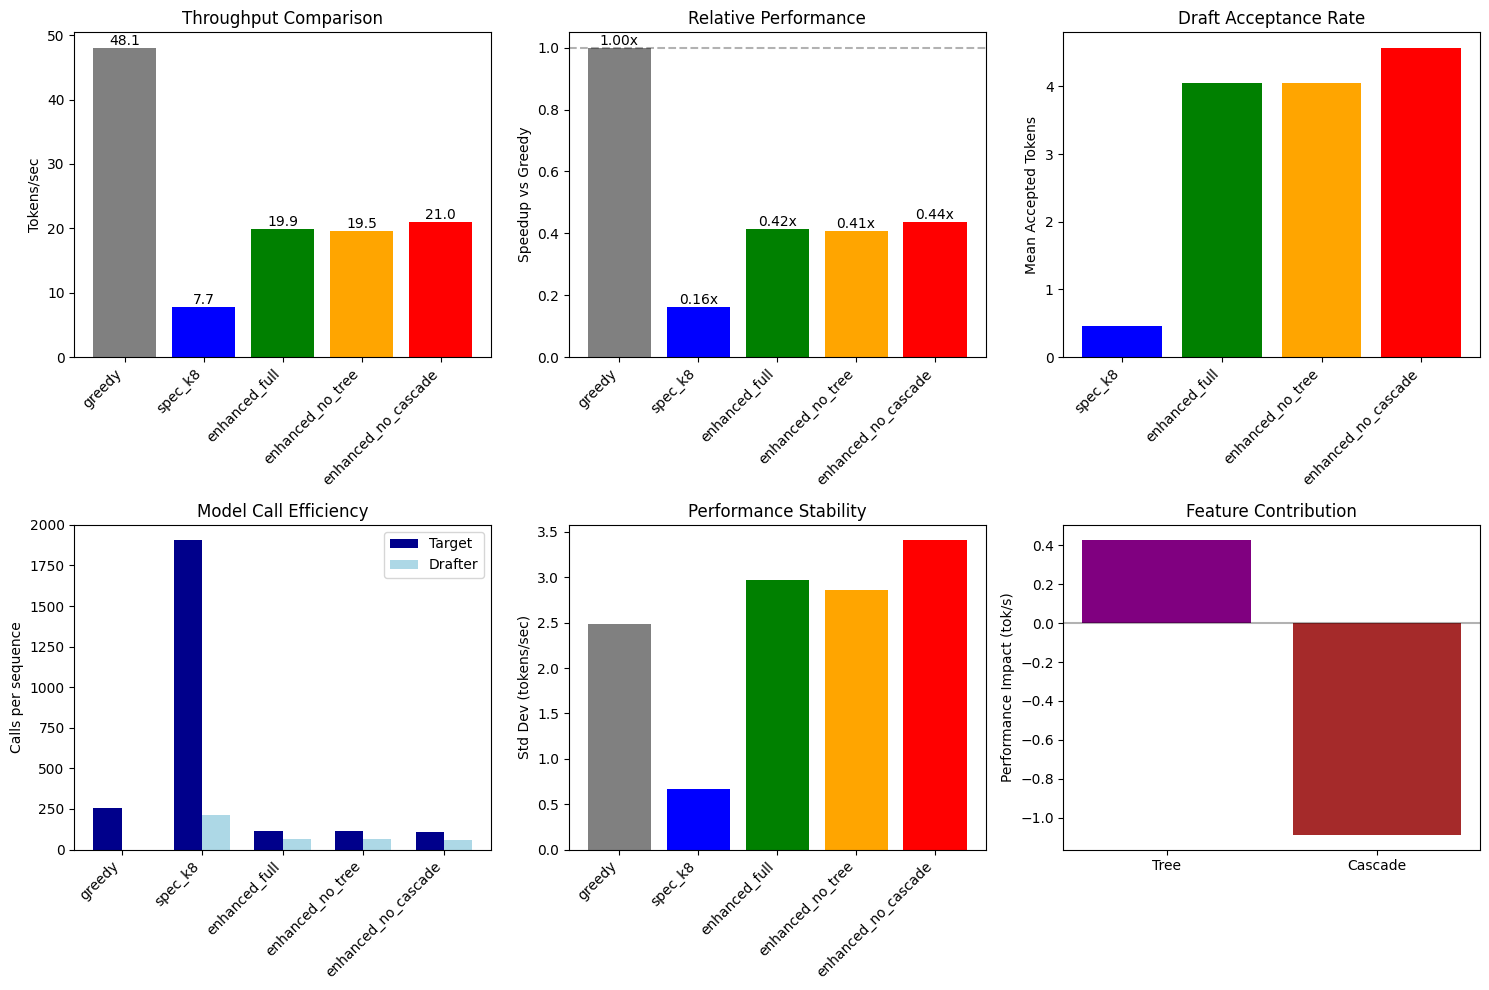


✓ Benchmark complete! Results saved to ./benchmark_results.png
✓ Detailed analysis saved to benchmark_analysis.csv

EXECUTIVE SUMMARY
Best performing method: greedy
Maximum speedup achieved: 1.00x over greedy
Average acceptance rate: 3.28 tokens/block

DETAILED COMPARISON
Standard Spec (k=8): 0.16x speedup
Enhanced V-Spec: 0.42x speedup
Improvement: 158.9% better than standard spec


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List

def get_test_prompts(n=20):
   prompts = []
   
   # Math problems
   prompts.extend([
       "Calculate 47 * 83 step by step.",
       "If a train travels 120 km at 60 km/h and then 180 km at 90 km/h, what's the average speed?",
       "Solve for x: 3x + 7 = 22. Show your work.",
   ])
   
   # Code tasks
   prompts.extend([
       "Write a Python function to find the nth Fibonacci number using dynamic programming.",
       "Implement a binary search tree in Python with insert and search methods.",
       "Create a function to validate if a string has balanced parentheses.",
   ])
   
   # Reasoning
   prompts.extend([
       "Explain how transformers work in machine learning to a beginner.",
       "What are the main causes of climate change? Provide a concise explanation.",
       "Describe the process of photosynthesis in simple terms.",
   ])
   
   # Story/Creative
   prompts.extend([
       "Write a short story about a robot learning to paint.",
       "Describe a futuristic city in the year 2150.",
   ])
   
   # Extend to n prompts by cycling
   while len(prompts) < n:
       prompts.extend(prompts[:min(n - len(prompts), len(prompts))])
   
   return prompts[:n]

def run_benchmark(n_prompts=16, max_new=256):
   prompts = get_test_prompts(n_prompts)
   results = {
       'greedy': [],
       'spec_k8': [],
       'enhanced_full': [],
       'enhanced_no_tree': [],
       'enhanced_no_cascade': []
   }
   
   print(f"Running benchmark on {n_prompts} prompts...")
   print("=" * 60)
   
   for i, prompt in enumerate(prompts):
       print(f"\n[{i+1}/{n_prompts}] Testing prompt: {prompt[:50]}...")
       
       # 1. Greedy baseline
       print("  Running greedy...", end="")
       greedy_res = run_greedy_cached(prompt, max_new=max_new)
       results['greedy'].append(greedy_res)
       print(f" {greedy_res['tokens_per_s']:.1f} tok/s")
       
       # 2. Standard spec (k=8)
       print("  Running spec(k=8)...", end="")
       spec_res = run_spec_block(prompt, k=8, max_new=max_new)
       results['spec_k8'].append(spec_res)
       print(f" {spec_res['tokens_per_s']:.1f} tok/s")
       
       # 3. Enhanced with all features
       print("  Running enhanced (full)...", end="")
       _, enhanced_res = run_enhanced_vspec(
           prompt, max_new=max_new, 
           use_tree=True, use_cascade=True, verbose=False
       )
       results['enhanced_full'].append(enhanced_res)
       print(f" {enhanced_res['tokens_per_sec']:.1f} tok/s")
       
       # 4. Enhanced without tree
       print("  Running enhanced (no tree)...", end="")
       _, enhanced_no_tree = run_enhanced_vspec(
           prompt, max_new=max_new,
           use_tree=False, use_cascade=True, verbose=False
       )
       results['enhanced_no_tree'].append(enhanced_no_tree)
       print(f" {enhanced_no_tree['tokens_per_sec']:.1f} tok/s")
       
       # 5. Enhanced without cascade
       print("  Running enhanced (no cascade)...", end="")
       _, enhanced_no_cascade = run_enhanced_vspec(
           prompt, max_new=max_new,
           use_tree=True, use_cascade=False, verbose=False
       )
       results['enhanced_no_cascade'].append(enhanced_no_cascade)
       print(f" {enhanced_no_cascade['tokens_per_sec']:.1f} tok/s")
   
   return results, prompts

print("Starting comprehensive benchmark...")
results, prompts = run_benchmark(n_prompts=12, max_new=256)

def analyze_results(results: Dict[str, List]):
   rows = []
   
   for method, res_list in results.items():
       if not res_list:
           continue
       
       if method == 'greedy':
           tps = [r['tokens_per_s'] for r in res_list]
           rows.append({
               'method': method,
               'mean_tps': np.mean(tps),
               'std_tps': np.std(tps),
               'median_tps': np.median(tps),
               'mean_accept': 1.0,
               'target_calls': np.mean([r['tgt_calls'] for r in res_list]),
               'drafter_calls': 0
           })
       else:
           tps_key = 'tokens_per_sec' if 'tokens_per_sec' in res_list[0] else 'tokens_per_s'
           tps = [r[tps_key] for r in res_list]
           
           accept_key = 'mean_accept' if 'mean_accept' in res_list[0] else 0
           mean_accept = np.mean([r.get(accept_key, 0) for r in res_list]) if accept_key else 0
           
           rows.append({
               'method': method,
               'mean_tps': np.mean(tps),
               'std_tps': np.std(tps),
               'median_tps': np.median(tps),
               'mean_accept': mean_accept,
               'target_calls': np.mean([r.get('tgt_calls', r.get('target_calls', 0)) for r in res_list]),
               'drafter_calls': np.mean([r.get('drafter_calls', r.get('d_calls', 0)) for r in res_list])
           })
   
   df = pd.DataFrame(rows)
   
   greedy_tps = df[df['method'] == 'greedy']['mean_tps'].values[0]
   df['speedup'] = df['mean_tps'] / greedy_tps
   
   return df

analysis = analyze_results(results)
print("\n" + "=" * 60)
print("BENCHMARK RESULTS")
print("=" * 60)
print(analysis.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Throughput comparison
ax = axes[0, 0]
methods = analysis['method'].values
throughputs = analysis['mean_tps'].values
colors = ['gray', 'blue', 'green', 'orange', 'red']
bars = ax.bar(methods, throughputs, color=colors[:len(methods)])
ax.set_ylabel('Tokens/sec')
ax.set_title('Throughput Comparison')
ax.set_xticklabels(methods, rotation=45, ha='right')
for bar, val in zip(bars, throughputs):
   ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
           f'{val:.1f}', ha='center', va='bottom')

# 2. Speedup over greedy
ax = axes[0, 1]
speedups = analysis['speedup'].values
bars = ax.bar(methods, speedups, color=colors[:len(methods)])
ax.set_ylabel('Speedup vs Greedy')
ax.set_title('Relative Performance')
ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.3)
ax.set_xticklabels(methods, rotation=45, ha='right')

for bar, val in zip(bars, speedups):
   ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
           f'{val:.2f}x', ha='center', va='bottom')

# 3. Acceptance rates
ax = axes[0, 2]
accept_rates = analysis['mean_accept'].values
bars = ax.bar(methods[1:], accept_rates[1:], color=colors[1:len(methods)])
ax.set_ylabel('Mean Accepted Tokens')
ax.set_title('Draft Acceptance Rate')
ax.set_xticklabels(methods[1:], rotation=45, ha='right')

# 4. Model calls comparison
ax = axes[1, 0]
target_calls = analysis['target_calls'].values
drafter_calls = analysis['drafter_calls'].values
x = np.arange(len(methods))
width = 0.35
ax.bar(x - width/2, target_calls, width, label='Target', color='darkblue')
ax.bar(x + width/2, drafter_calls, width, label='Drafter', color='lightblue')
ax.set_ylabel('Calls per sequence')
ax.set_title('Model Call Efficiency')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()

# 5. Variance analysis
ax = axes[1, 1]
std_tps = analysis['std_tps'].values
ax.bar(methods, std_tps, color=colors[:len(methods)])
ax.set_ylabel('Std Dev (tokens/sec)')
ax.set_title('Performance Stability')
ax.set_xticklabels(methods, rotation=45, ha='right')

# 6. Feature ablation impact
ax = axes[1, 2]
if 'enhanced_full' in analysis['method'].values:
   base_idx = analysis[analysis['method'] == 'enhanced_full'].index[0]
   base_tps = analysis.loc[base_idx, 'mean_tps']
   
   ablation_data = []
   if 'enhanced_no_tree' in analysis['method'].values:
       no_tree_idx = analysis[analysis['method'] == 'enhanced_no_tree'].index[0]
       ablation_data.append(('Tree', base_tps - analysis.loc[no_tree_idx, 'mean_tps']))
   
   if 'enhanced_no_cascade' in analysis['method'].values:
       no_cascade_idx = analysis[analysis['method'] == 'enhanced_no_cascade'].index[0]
       ablation_data.append(('Cascade', base_tps - analysis.loc[no_cascade_idx, 'mean_tps']))
   
   if ablation_data:
       features, impacts = zip(*ablation_data)
       ax.bar(features, impacts, color=['purple', 'brown'])
       ax.set_ylabel('Performance Impact (tok/s)')
       ax.set_title('Feature Contribution')
       ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{os.environ.get('BASE_DIR', '.')}/benchmark_results.png", dpi=150)
plt.show()

print(f"\nBenchmark complete! Results saved to {os.environ.get('BASE_DIR', '.')}/benchmark_results.png")

analysis.to_csv(f"{os.environ.get('BASE_DIR', '.')}/benchmark_analysis.csv", index=False)
print(f"Detailed analysis saved to benchmark_analysis.csv")

print("\n" + "=" * 60)
print("EXECUTIVE SUMMARY")
print("=" * 60)
best_method = analysis.loc[analysis['speedup'].idxmax(), 'method']
best_speedup = analysis.loc[analysis['speedup'].idxmax(), 'speedup']
print(f"Best performing method: {best_method}")
print(f"Maximum speedup achieved: {best_speedup:.2f}x over greedy")
print(f"Average acceptance rate: {analysis[analysis['method'] != 'greedy']['mean_accept'].mean():.2f} tokens/block")

print("\n" + "=" * 60)
print("DETAILED COMPARISON")
print("=" * 60)
if 'enhanced_full' in analysis['method'].values:
   enhanced_idx = analysis[analysis['method'] == 'enhanced_full'].index[0]
   spec_idx = analysis[analysis['method'] == 'spec_k8'].index[0]
   
   enhanced_speedup = analysis.loc[enhanced_idx, 'speedup']
   spec_speedup = analysis.loc[spec_idx, 'speedup']
   improvement = ((enhanced_speedup - spec_speedup) / spec_speedup) * 100
   
   print(f"Standard Spec (k=8): {spec_speedup:.2f}x speedup")
   print(f"Enhanced V-Spec: {enhanced_speedup:.2f}x speedup")
   print(f"Improvement: {improvement:.1f}% better than standard spec")

In [ ]:
def quick_test(prompt=None, max_tokens=256):
    if prompt is None:
        prompt = "Explain how neural networks learn in simple terms."
    
    print(f"\n{'='*60}")
    print(f"PROMPT: {prompt}")
    print(f"{'='*60}")
    
    results = {}
    
    # 1. Greedy
    print("\n1. GREEDY BASELINE")
    print("-" * 20)
    t0 = time.perf_counter()
    greedy_res = run_greedy_cached(prompt, max_new=max_tokens)
    greedy_time = time.perf_counter() - t0
    results['greedy'] = greedy_res
    print(f"Speed: {greedy_res['tokens_per_s']:.2f} tokens/sec")
    print(f"Time: {greedy_time:.2f}s")
    print(f"Target calls: {greedy_res['tgt_calls']}")
    
    # 2. Standard Spec
    print("\n2. STANDARD SPECULATIVE (k=8)")
    print("-" * 20)
    spec_res = run_spec_block(prompt, k=8, max_new=max_tokens)
    results['spec'] = spec_res
    print(f"Speed: {spec_res['tokens_per_s']:.2f} tokens/sec")
    print(f"Speedup: {spec_res['tokens_per_s']/greedy_res['tokens_per_s']:.2f}x")
    print(f"Mean accept: {spec_res['mean_accept']:.2f}")
    print(f"Target calls: {spec_res['tgt_calls']}")
    
    # 3. Enhanced V-Spec
    print("\n3. ENHANCED V-SPEC (Full)")
    print("-" * 20)
    text, enhanced_res = run_enhanced_vspec(
        prompt, max_new=max_tokens, 
        use_tree=True, use_cascade=True, verbose=False
    )
    results['enhanced'] = enhanced_res
    print(f"Speed: {enhanced_res['tokens_per_sec']:.2f} tokens/sec")
    print(f"Speedup: {enhanced_res['tokens_per_sec']/greedy_res['tokens_per_s']:.2f}x")
    print(f"Mean accept: {enhanced_res['mean_accept']:.2f}")
    print(f"Accept rate: {enhanced_res['accept_rate']:.2%}")
    print(f"Target calls: {enhanced_res['target_calls']}")
    
    print(f"\n{'='*60}")
    print("IMPROVEMENTS")
    print(f"{'='*60}")
    spec_improvement = ((enhanced_res['tokens_per_sec'] - spec_res['tokens_per_s']) / spec_res['tokens_per_s']) * 100
    print(f"Enhanced vs Standard Spec: {spec_improvement:+.1f}%")
    
    greedy_improvement = ((enhanced_res['tokens_per_sec'] - greedy_res['tokens_per_s']) / greedy_res['tokens_per_s']) * 100
    print(f"Enhanced vs Greedy: {greedy_improvement:+.1f}%")
    
    print(f"\n{'='*60}")
    print("SAMPLE OUTPUT (first 200 chars):")
    print(f"{'='*60}")
    print(text[:200] + "...")
    
    return results

def profile_performance(prompt="Write a Python function to sort a list.", max_tokens=128):
    print(f"\n{'='*60}")
    print("PERFORMANCE PROFILING")
    print(f"{'='*60}")
    print(f"Prompt: {prompt}")
    
    monitor.enabled = True
    monitor.timings.clear()
    monitor.counts.clear()
    
    _, stats = run_enhanced_vspec(
        prompt, max_new=max_tokens,
        use_tree=True, use_cascade=True, verbose=False
    )
    
    print(f"\nTotal time: {stats['time']:.3f}s")
    print(f"Tokens generated: {max_tokens}")
    print(f"Speed: {stats['tokens_per_sec']:.2f} tokens/sec")
    
    print("\nTime breakdown:")
    print("-" * 40)
    
    if stats['time_breakdown']:
        sorted_timings = sorted(
            stats['time_breakdown'].items(),
            key=lambda x: x[1]['total_s'],
            reverse=True
        )
        
        total_tracked = sum(t[1]['total_s'] for t in sorted_timings)
        
        for name, info in sorted_timings:
            pct = (info['total_s'] / stats['time']) * 100
            print(f"{name:20s}: {info['total_s']:.3f}s ({pct:5.1f}%) "
                  f"[{info['count']:3d} calls, {info['mean_ms']:.2f}ms avg]")
        
        untracked = stats['time'] - total_tracked
        untracked_pct = (untracked / stats['time']) * 100
        print(f"{'Untracked':20s}: {untracked:.3f}s ({untracked_pct:5.1f}%)")
    
    print("\nKey metrics:")
    print("-" * 40)
    print(f"Target calls: {stats['target_calls']}")
    print(f"Drafter calls: {stats['drafter_calls']}")
    print(f"Blocks verified: {stats['blocks']}")
    print(f"Mean acceptance: {stats['mean_accept']:.2f} tokens/block")
    print(f"Tree explorations: {stats['tree_explores']}")
    if stats['cascade_stages']:
        print(f"Avg cascade stage: {np.mean(stats['cascade_stages']):.2f}")
    
    return stats

def compare_on_prompt_types():
    prompt_types = {
        'math': "Calculate 1247 * 892 step by step, showing all work.",
        'code': "Write a Python function to implement quicksort with detailed comments.",
        'reasoning': "Explain the theory of relativity to a 10-year-old.",
        'creative': "Write a haiku about artificial intelligence.",
        'factual': "List the main causes of the French Revolution.",
    }
    
    results = {}
    print(f"\n{'='*60}")
    print("PERFORMANCE BY PROMPT TYPE")
    print(f"{'='*60}")
    
    for ptype, prompt in prompt_types.items():
        print(f"\n{ptype.upper()}: {prompt[:50]}...")
    
        greedy = run_greedy_cached(prompt, max_new=128)
        
        _, enhanced = run_enhanced_vspec(
            prompt, max_new=128,
            use_tree=True, use_cascade=True, verbose=False
        )
        
        speedup = enhanced['tokens_per_sec'] / greedy['tokens_per_s']
        results[ptype] = {
            'greedy_tps': greedy['tokens_per_s'],
            'enhanced_tps': enhanced['tokens_per_sec'],
            'speedup': speedup,
            'mean_accept': enhanced['mean_accept']
        }
        
        print(f"  Greedy: {greedy['tokens_per_s']:.1f} tok/s")
        print(f"  Enhanced: {enhanced['tokens_per_sec']:.1f} tok/s")
        print(f"  Speedup: {speedup:.2f}x")
        print(f"  Acceptance: {enhanced['mean_accept']:.1f} tokens/block")
    
    print(f"\n{'='*60}")
    print("SUMMARY BY TYPE")
    print(f"{'='*60}")
    
    df_types = pd.DataFrame(results).T
    df_types = df_types.sort_values('speedup', ascending=False)
    print(df_types.to_string())
    
    return results

def test_adaptive_behavior(prompt="Explain machine learning.", iterations=5):
    print(f"\n{'='*60}")
    print("ADAPTIVE BEHAVIOR TEST")
    print(f"{'='*60}")
    print(f"Running same prompt {iterations} times to see adaptation...")
    
    results = []
    for i in range(iterations):
        print(f"\nIteration {i+1}/{iterations}")
        _, stats = run_enhanced_vspec(
            prompt, max_new=100,
            use_tree=True, use_cascade=True, verbose=False
        )
        results.append({
            'iteration': i+1,
            'tps': stats['tokens_per_sec'],
            'mean_accept': stats['mean_accept'],
            'target_calls': stats['target_calls']
        })
        print(f"  Speed: {stats['tokens_per_sec']:.1f} tok/s")
        print(f"  Acceptance: {stats['mean_accept']:.1f}")
    tps_values = [r['tps'] for r in results]
    print(f"\n{'='*60}")
    print("STATISTICS")
    print(f"{'='*60}")
    print(f"Mean speed: {np.mean(tps_values):.1f} ± {np.std(tps_values):.1f} tok/s")
    print(f"Min speed: {np.min(tps_values):.1f} tok/s")
    print(f"Max speed: {np.max(tps_values):.1f} tok/s")
    print(f"Coefficient of variation: {np.std(tps_values)/np.mean(tps_values):.2%}")
    
    return results

print("=" * 60)
print("INTERACTIVE DEMO FUNCTIONS")
print("=" * 60)
print("\n1. quick_test(prompt, max_tokens)")
print("   - Compare all methods on a single prompt")
print("   - Example: quick_test('Explain quantum computing', 256)")
print("\n2. profile_performance(prompt, max_tokens)")
print("   - Detailed performance profiling")
print("   - Shows where time is spent")
print("\n3. compare_on_prompt_types()")
print("   - Test on different prompt categories")
print("   - Math, code, reasoning, creative, factual")
print("\n4. test_adaptive_behavior(prompt, iterations)")
print("   - Test consistency across multiple runs")
print("\n" + "=" * 60)

print("\nRunning quick demo...")
demo_results = quick_test("What are the benefits of renewable energy?", max_tokens=128)

_ = quick_test("What is transfer learning?", max_tokens=128)
_ = profile_performance("Implement a binary search in Python.", max_tokens=128)
by_type = compare_on_prompt_types()
adapt   = test_adaptive_behavior("How does a transformer model work?", iterations=3)


INTERACTIVE DEMO FUNCTIONS

1. quick_test(prompt, max_tokens)
   - Compare all methods on a single prompt
   - Example: quick_test('Explain quantum computing', 256)

2. profile_performance(prompt, max_tokens)
   - Detailed performance profiling
   - Shows where time is spent

3. compare_on_prompt_types()
   - Test on different prompt categories
   - Math, code, reasoning, creative, factual

4. test_adaptive_behavior(prompt, iterations)
   - Test consistency across multiple runs


Running quick demo...

PROMPT: What are the benefits of renewable energy?

1. GREEDY BASELINE
--------------------
Speed: 44.76 tokens/sec
Time: 2.89s
Target calls: 128

2. STANDARD SPECULATIVE (k=8)
--------------------
Speed: 4.20 tokens/sec
Speedup: 0.09x
Mean accept: 0.49
Target calls: 927

3. ENHANCED V-SPEC (Full)
--------------------
Speed: 11.22 tokens/sec
Speedup: 0.25x
Mean accept: 3.53
Accept rate: 55.46%
Target calls: 64

IMPROVEMENTS
Enhanced vs Standard Spec: +167.1%
Enhanced vs Greedy: -74.9%

S

KeyboardInterrupt: 